<center>
    <h1>Cloud Movement Diffusion</h1>
    <h2>Artificial Intelligence in Industry</h2>
    <h3>Facundo Nicolas Maidana, Farshid Mahmoudabadi, and Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This project explores the use of diffusion models for short-term solar energy forecasting. Diffusion models are a type of generative model that can be used to predict the future state of a system by gradually "diffusing" from the current state. In this project, we train a diffusion model on a dataset of cloud images. We then use the model to predict the future state of the clouds, which can be used to forecast solar energy production.

Introduction:

Solar energy is a promising renewable energy source, but it is intermittent. This means that the amount of solar energy produced can vary significantly from day to day. Short-term solar energy forecasting can help to mitigate this variability by providing estimates of solar energy production in the near future.

Diffusion models:

Diffusion models are a type of generative model that can be used to predict the future state of a system by gradually "diffusing" from the current state. Diffusion models are trained on a dataset of images, and they can be used to generate new images that are similar to the images in the dataset.

Project goals:

The goals of this project are to:

Train a diffusion model on a dataset of cloud images.
Use the model to predict the future state of the clouds.
Use the predicted cloud state to forecast solar energy production.

Project results:

The results of this project show that diffusion models can be used to predict the future state of the clouds with some accuracy. The predicted cloud state can then be used to forecast solar energy production.

# Settings

In [ ]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -r requirements.txt

In [ ]:
from types import SimpleNamespace

# TODO: Some of these parameters are not used, remove them.
config = SimpleNamespace(
    epochs=101, # Number of epochs.
    model_name='unet_small', # Model name to save [unet_small, unet_big].
    strategy='ddpm', # Strategy to use ddpm.
    noise_steps=1_000, # Number of noise steps on the diffusion process.
    sampler_steps=333, # Number of sampler steps on the diffusion process.
    seed=42, # Random seed.
    batch_size=128, # Batch size.
    img_size=64, # Image size.
    device='cuda', # Device to use.
    num_workers=0, # Number of workers for dataloader.
    num_input_frames=3, # Number of frames to use as input for the training.
    lr=5e-4, # Learning rate.
    log_every_epoch=5, # Log every n epochs to wandb.
    num_prediction_frames=1, # Number of predictions to make.
    num_channels=2, # Number of channels.
    validate_epochs=False, # Whether to validate every epoch.
    )

# Dataset

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: riccardo-spolaor94 (ai-industry). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Dataset class

DummyNextFrameDataset. The CloudDataset class is used to load a dataset of cloud images from a WandB artifact. The DummyNextFrameDataset class is a simple dummy dataset that can be used for testing.

1. The CloudDataset class has the following methods:

__init__(): This method initializes the class and loads the dataset from the WandB artifact.
load_data(): This method loads the data from the WandB artifact and creates a single array of images.
create_windows(): This method creates a sequence of windows from the array of images. A window is a sequence of consecutive frames.

__getitem__(): This method returns a single image from the dataset.

__len__(): This method returns the length of the dataset.


2. The DummyNextFrameDataset class has the following methods:

__init__(): This method initializes the class and sets the number of frames and the image size.

__getitem__(): This method returns a random image.

__len__(): This method returns the number of images in the dataset.
The download_dataset() function downloads the dataset from the WandB artifact.

## training

In [ ]:
PROJECT_NAME = 'sevir'
DATASET_ARTIFACT = 'ai-industry/sevir/SEVIR:latest'
SCALERS_ARTIFACT = 'ai-industry/sevir/scalers:latest'

'ai-industry/sevir/SEVIR:latest'

In [ ]:
import torch

from src.seeder import set_seed
from src.model import get_unet_params
from src.dataset_builder import download_dataset, download_scalers
from src.scaler import Scaler

# Set the model parameters in the config file.
'''config.model_params = get_unet_params(
    model_name=config.model_name,
    num_frames=10)''';

# Set the model parameters in the config file.
# TODO: base num_frames on config
config.model_params = get_unet_params(
    model_name=config.model_name,
    num_input_frames=config.num_input_frames + config.num_prediction_frames,
    num_output_frames=config.num_prediction_frames,
    num_channels=config.num_channels)

# Set the seed and device.
set_seed(config.seed)
device = torch.device(config.device)

# Downlaod the dataset from the wandb Artifact.
files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
scalers = download_scalers(SCALERS_ARTIFACT, PROJECT_NAME)

wandb: Downloading large artifact SEVIR:latest, 8544.38MB. 9 files... 
wandb:   9 of 9 files downloaded.  
Done. 0:0:5.6


wandb: \ 1 of 3 files downloaded...
wandb:   3 of 3 files downloaded.  


In [ ]:
from src.dataset_builder import CloudDataset

# Build the train and validation datasets.
# TODO: put num_frames in config.
train_ds = CloudDataset(
    files=files[1:5:3], # Use just ir069 and ir107 training images.
    num_frames=config.num_input_frames + config.num_prediction_frames, # Use 3 frames as input and 1 frame as prediction.
    img_size=config.img_size, # Image size.
    scalers=scalers[:2] # Use just ir069 and ir107 scaler.
    ).shuffle()
valid_ds = CloudDataset(
    files=files[2:6:3], # Use just ir069 and ir107 validation images.
    num_frames=config.num_input_frames + 3, # Use 3 frames as input and 3 frames as target.
    img_size=config.img_size, # Image size.
    scalers=scalers[:2]) # Use just ir069 and ir107 scaler.

In [ ]:
from src.dataloader import NoisifyDataloader, ValidationDataloader
from src.model import UNet2D
from src.sampler import ddim_sampler
from src.training import MiniTrainer


# Build the DDPM noise train and validation dataloaders.
train_dataloader = NoisifyDataloader(
    train_ds,
    config.batch_size,
    shuffle=True,
    n_frames_to_nosify=config.num_prediction_frames,
    num_workers=config.num_workers)

valid_dataloader = ValidationDataloader(
    valid_ds,
    config.batch_size,
    n_past_frames=config.num_input_frames,
    shuffle=False,
    num_workers=config.num_workers)

# Setup the model.
model = UNet2D(**config.model_params)

# Setup the sampler.
sampler = ddim_sampler(
    steps=config.sampler_steps,
    n_frames_to_predict=config.num_prediction_frames,
    n_channels=config.num_channels)

# Get the trainer.
trainer = MiniTrainer(
    train_dataloader,
    valid_dataloader,
    model,
    sampler,
    scalers[0],
    device,
    n_frames_to_predict=config.num_prediction_frames,
    n_auto_regression_steps=3)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


validation epoch=0, val PSNR=-3.384, val SSIM=0.002, val MSE=0.499, val mCSI=0.000
(64, 192)


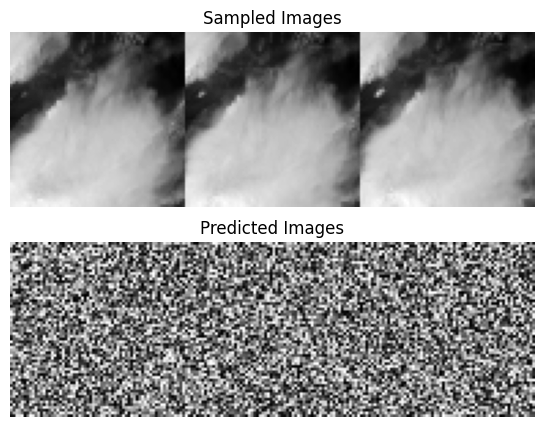

validation epoch=5, val PSNR=-3.288, val SSIM=0.002, val MSE=0.488, val mCSI=0.000
(64, 192)


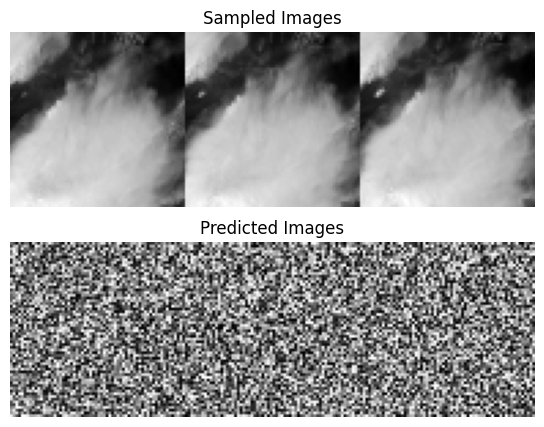

validation epoch=10, val PSNR=-2.716, val SSIM=0.002, val MSE=0.427, val mCSI=0.000
(64, 192)


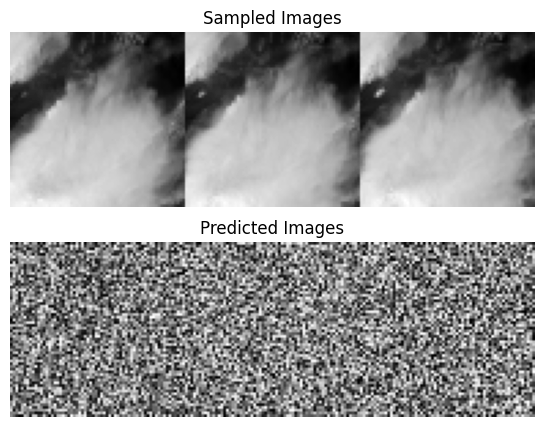

validation epoch=15, val PSNR=-1.238, val SSIM=0.006, val MSE=0.304, val mCSI=0.000
(64, 192)


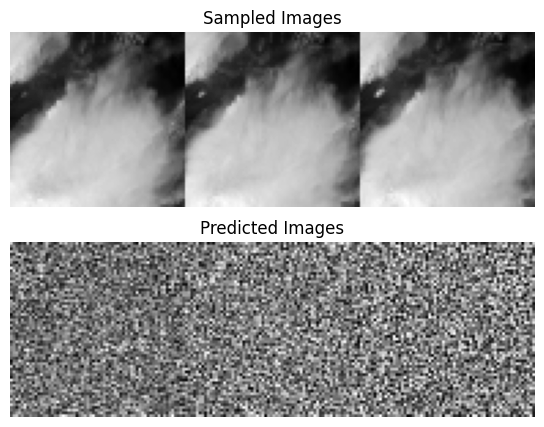

validation epoch=20, val PSNR=2.636, val SSIM=0.083, val MSE=0.125, val mCSI=0.000
(64, 192)


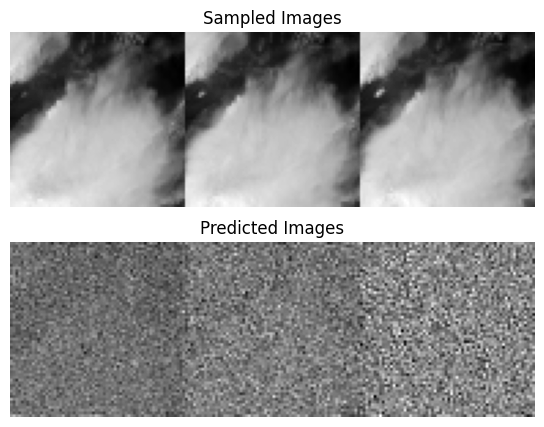

validation epoch=25, val PSNR=6.211, val SSIM=0.313, val MSE=0.055, val mCSI=0.000
(64, 192)


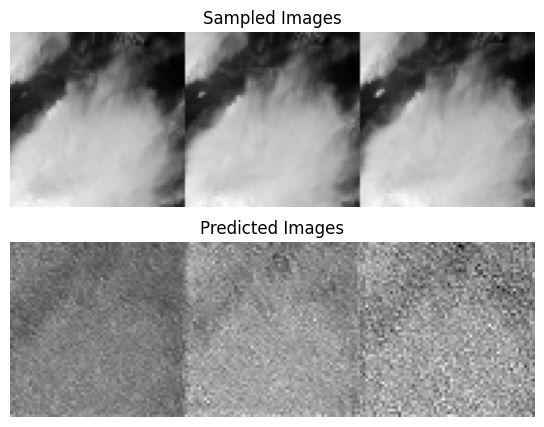

validation epoch=30, val PSNR=7.308, val SSIM=0.572, val MSE=0.043, val mCSI=0.000
(64, 192)


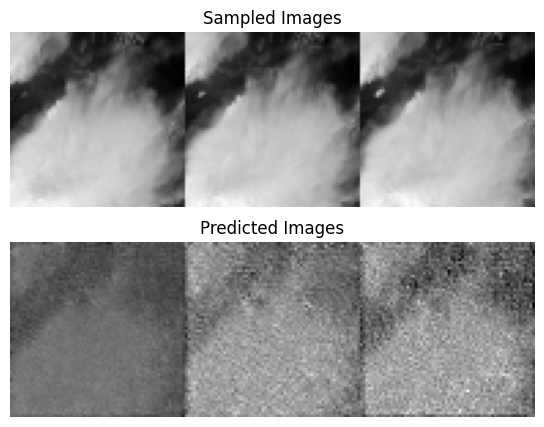

validation epoch=35, val PSNR=9.926, val SSIM=0.683, val MSE=0.023, val mCSI=0.000
(64, 192)


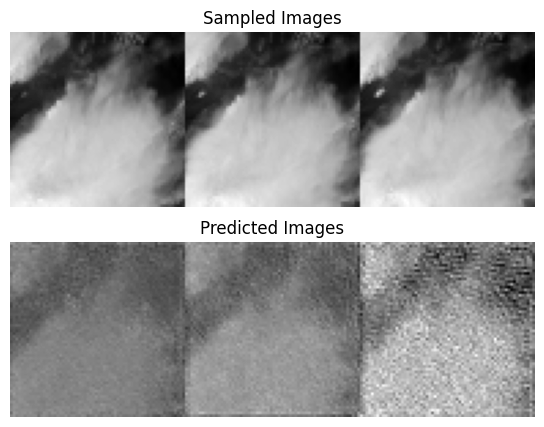

validation epoch=40, val PSNR=8.426, val SSIM=0.694, val MSE=0.033, val mCSI=0.000
(64, 192)


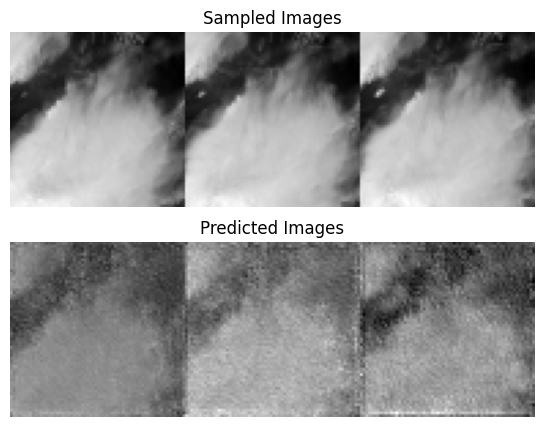

validation epoch=45, val PSNR=7.210, val SSIM=0.598, val MSE=0.043, val mCSI=0.000
(64, 192)


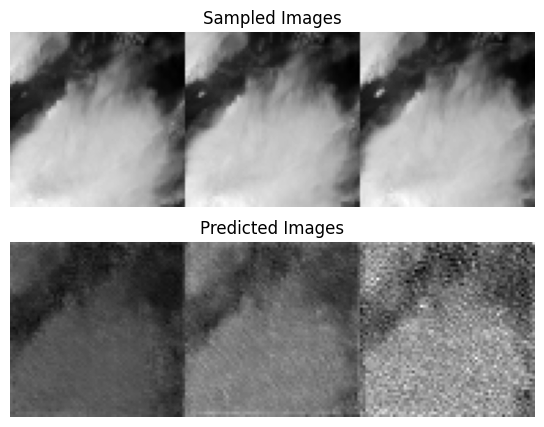

validation epoch=50, val PSNR=13.435, val SSIM=0.760, val MSE=0.010, val mCSI=0.000
(64, 192)


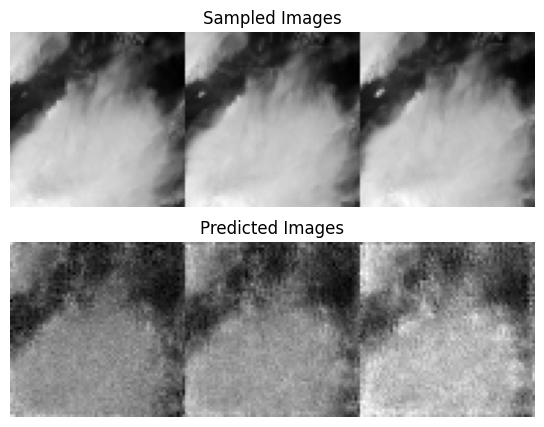

validation epoch=55, val PSNR=16.343, val SSIM=0.719, val MSE=0.005, val mCSI=0.000
(64, 192)


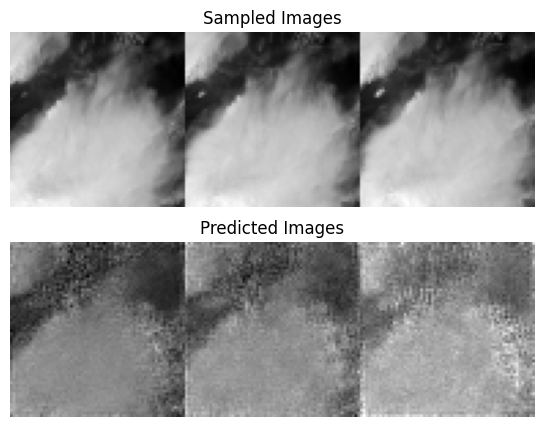

validation epoch=60, val PSNR=13.421, val SSIM=0.740, val MSE=0.010, val mCSI=0.000
(64, 192)


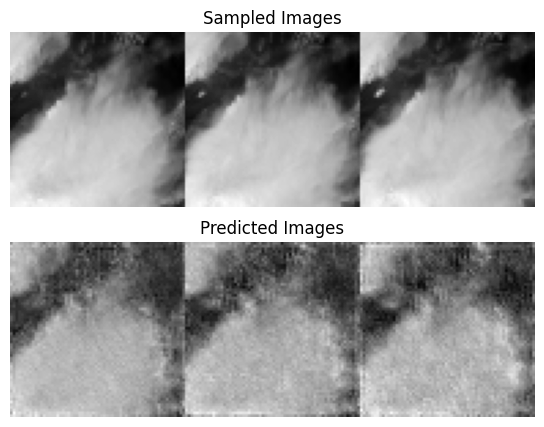

validation epoch=65, val PSNR=14.648, val SSIM=0.803, val MSE=0.008, val mCSI=0.000
(64, 192)


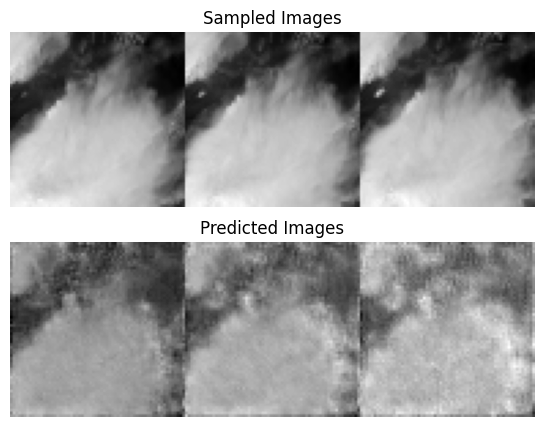

validation epoch=70, val PSNR=12.457, val SSIM=0.836, val MSE=0.013, val mCSI=0.000
(64, 192)


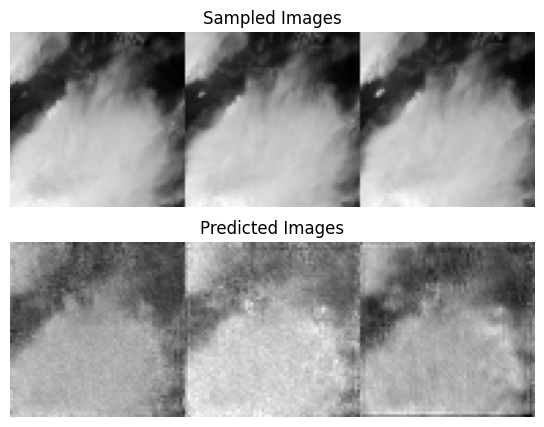

validation epoch=75, val PSNR=14.493, val SSIM=0.717, val MSE=0.008, val mCSI=0.000
(64, 192)


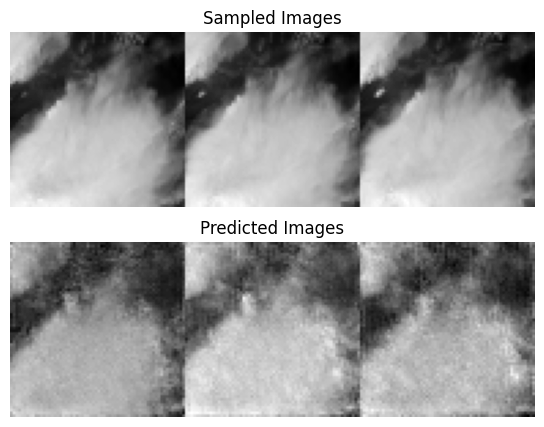

validation epoch=80, val PSNR=14.148, val SSIM=0.775, val MSE=0.009, val mCSI=0.000
(64, 192)


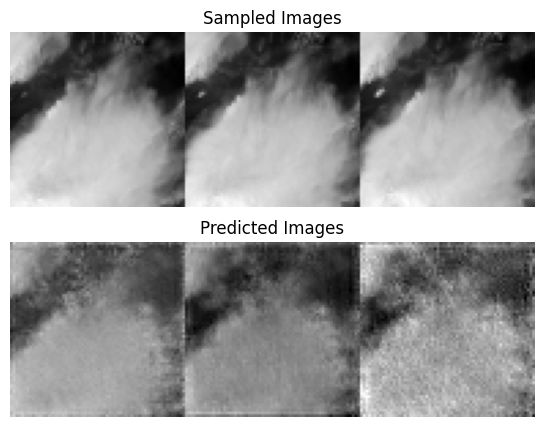

validation epoch=85, val PSNR=13.492, val SSIM=0.857, val MSE=0.010, val mCSI=0.000
(64, 192)


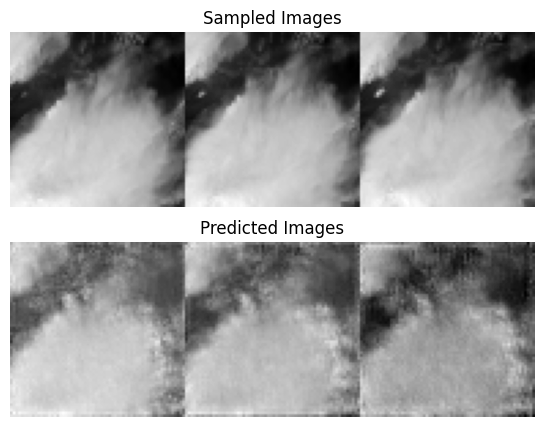

validation epoch=90, val PSNR=14.412, val SSIM=0.734, val MSE=0.008, val mCSI=0.000
(64, 192)


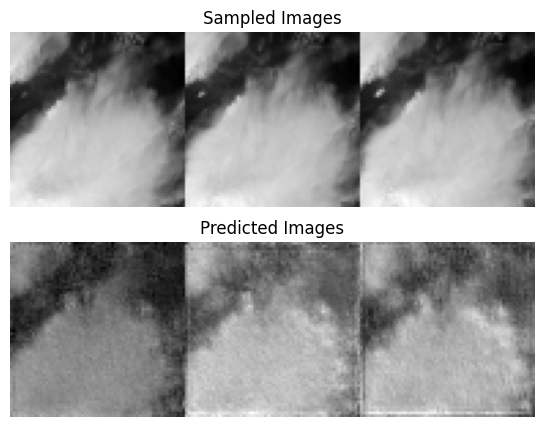

validation epoch=95, val PSNR=14.586, val SSIM=0.727, val MSE=0.008, val mCSI=0.000
(64, 192)


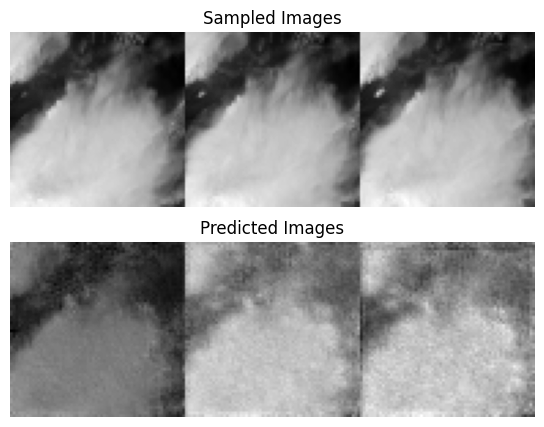

validation epoch=100, val PSNR=15.006, val SSIM=0.790, val MSE=0.007, val mCSI=0.000
(64, 192)


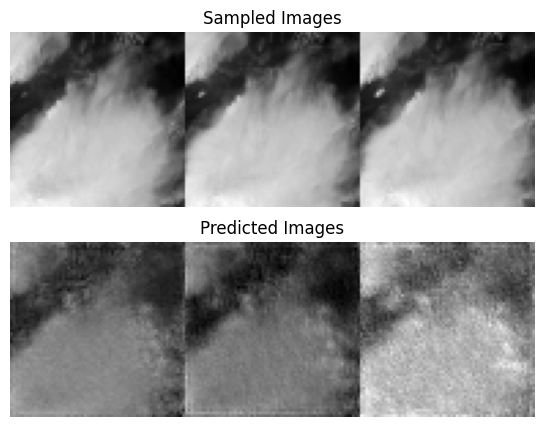

In [ ]:
# trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)

# Train the model.
with wandb.init(
    project='cloud-diffuser-baseline-autoregression-multichannel',
    entity='ai-industry',
    config=config,
    tags=['ddpm', config.model_name]
    ):
    histories = trainer.fit(config)

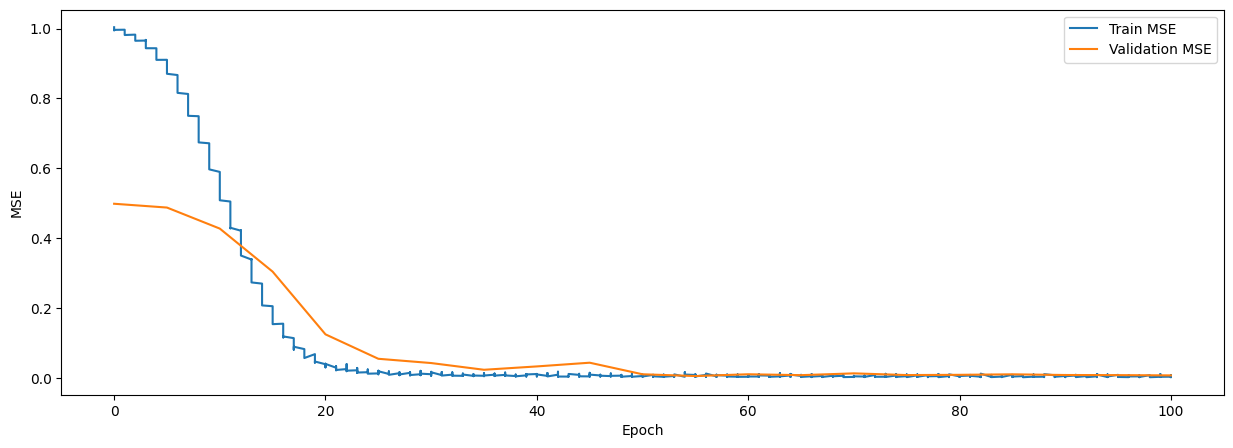

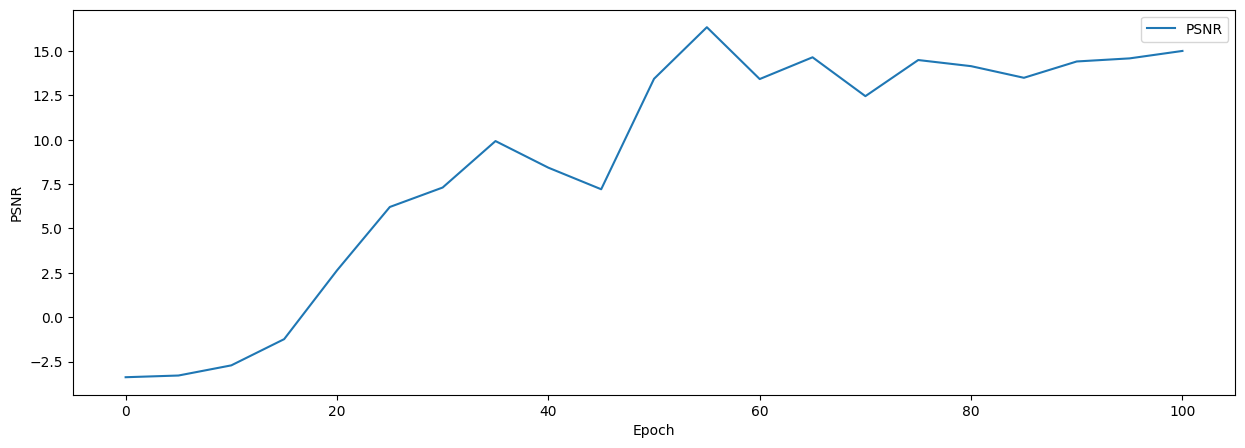

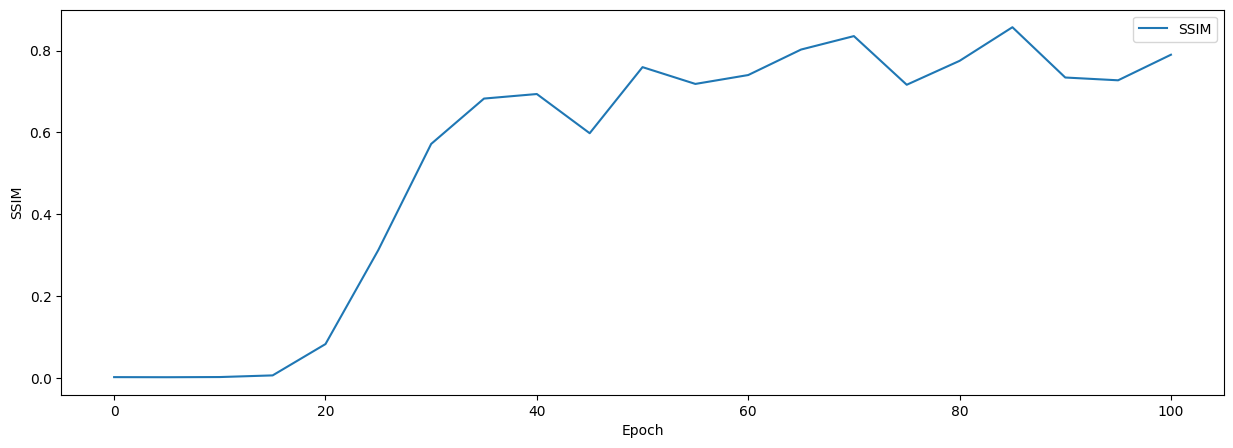

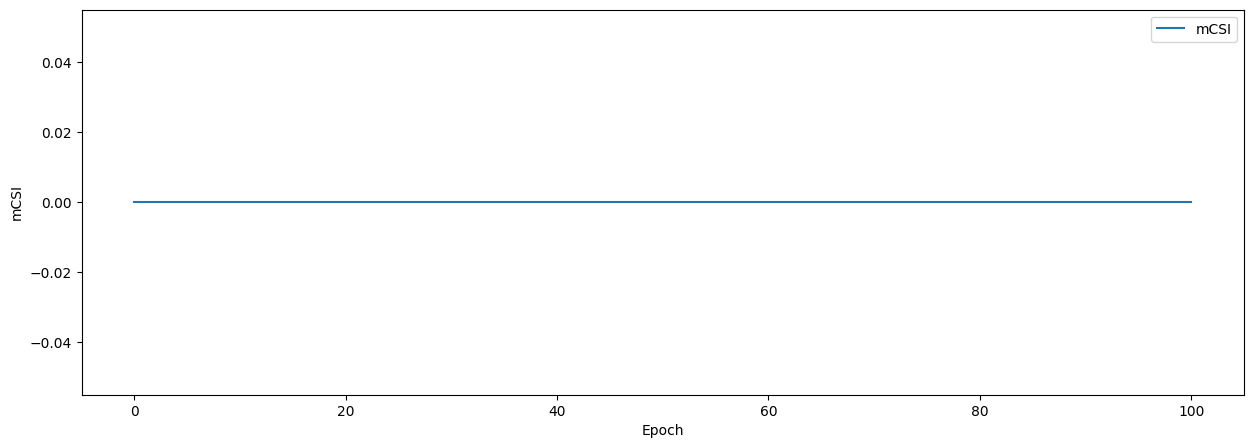

In [ ]:
from src.visualization import plot_metrics

plot_metrics(
    *histories[:2],
    PSNR=histories[2],
    SSIM=histories[3],
    mCSI=histories[4])